In [10]:
import torch
import os
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms

seed = 45
torch.manual_seed(seed)

In [11]:
train_benign_folder_path = "skin cancer data/train/benign"
test_benign_folder_path = "skin cancer data/test/benign"

train_malignant_folder_path = "skin cancer data/train/malignant"
test_malignant_folder_path = "skin cancer data/test/malignant"

In [12]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),  #<<<-----        
])

def get_tensor_images(folder_path):
    image_tensors = []
    for image_name in os.listdir(folder_path):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
            image_path = os.path.join(folder_path, image_name)
            image = Image.open(image_path).convert("RGB")   # Open and convert image to RGB
            image_tensor = transform(image)                # Apply the transform
            image_tensors.append(image_tensor)
    print("shape of one image tensor ",image_tensors[0].shape)
    print("len of list image tensors",len(image_tensors))
    # Stack all image tensors into a single tensor
    all_images_tensor = torch.stack(image_tensors)
    print("Shape of the tensor:", all_images_tensor.shape)
    print("\n")
    return all_images_tensor

In [16]:
train_benign_tensor=get_tensor_images(train_benign_folder_path)
test_benign_tesnor=get_tensor_images(test_benign_folder_path)

train_malignant_tensor=get_tensor_images(train_malignant_folder_path)
test_malignant_tesnor=get_tensor_images(test_malignant_folder_path)

shape of one image tensor  torch.Size([3, 224, 224])
len of list image tensors 1440
Shape of the tensor: torch.Size([1440, 3, 224, 224])


shape of one image tensor  torch.Size([3, 224, 224])
len of list image tensors 360
Shape of the tensor: torch.Size([360, 3, 224, 224])


shape of one image tensor  torch.Size([3, 224, 224])
len of list image tensors 1197
Shape of the tensor: torch.Size([1197, 3, 224, 224])


shape of one image tensor  torch.Size([3, 224, 224])
len of list image tensors 300
Shape of the tensor: torch.Size([300, 3, 224, 224])




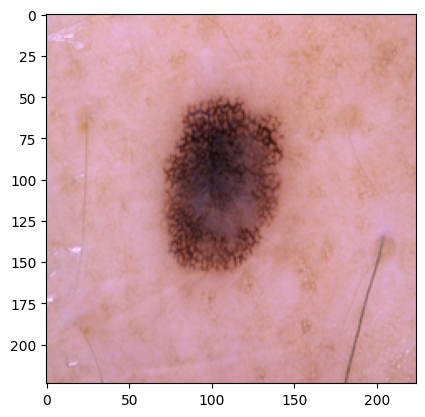

In [15]:
plt.imshow(train_benign_tensor[0].permute(1, 2, 0))
plt.show()

In [20]:
train_benign_labels=torch.ones(train_benign_tensor.shape[0], dtype=torch.long)# benign ---> 1
train_malignant_lables=torch.zeros(train_malignant_tensor.shape[0], dtype=torch.long)# malignnat ---> 0

test_benign_labels=torch.ones(test_benign_tesnor.shape[0], dtype=torch.long)# benign ---> 1
test_malignant_lables=torch.zeros(test_malignant_tesnor.shape[0], dtype=torch.long)# malignnat ---> 0

train_benign_labels.shape,train_malignant_lables.shape,test_benign_labels.shape,test_malignant_lables.shape

(torch.Size([1440]), torch.Size([1197]), torch.Size([360]), torch.Size([300]))

In [22]:
train_images = torch.cat((train_benign_tensor, train_malignant_tensor), dim=0)
train_labels=torch.cat((train_benign_labels, train_malignant_lables), dim=0)

test_images = torch.cat((test_benign_tesnor, test_malignant_tesnor), dim=0)
test_labels=torch.cat((test_benign_labels, test_malignant_lables), dim=0)

shuffled_indices = torch.randperm(train_images.size(0))  
train_images = train_images[shuffled_indices]
train_labels=train_labels[shuffled_indices]

shuffled_indices = torch.randperm(test_images.size(0))  
test_images = test_images[shuffled_indices]
test_labels=test_labels[shuffled_indices]

print(train_images.shape)
print(train_labels.shape)

print(test_images.shape)
print(test_labels.shape)

torch.Size([2637, 3, 224, 224])
torch.Size([2637])
torch.Size([660, 3, 224, 224])
torch.Size([660])


In [23]:
train_mean = train_images.mean(dim=[0, 2, 3], keepdim=True)  # Mean for each channel (RGB)
train_std = train_images.std(dim=[0, 2, 3], keepdim=True)    # Std for each channel (RGB)
train_images = (train_images - train_mean) / train_std
test_images = (test_images - train_mean) / train_std

train_mean,train_std

(tensor([[[[0.7602]],
 
          [[0.5367]],
 
          [[0.5379]]]]),
 tensor([[[[0.1517]],
 
          [[0.1601]],
 
          [[0.1766]]]]))

In [24]:
train_map = [(img, label) for img, label in zip(train_images, train_labels)]
test_map = [(img, label) for img, label in zip(test_images, test_labels)]


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super().__init__()                   #64*64
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1) 
        self.conv2 = nn.Conv2d(16, 8, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(8 * 56 * 56, 32)
        self.fc2 = nn.Linear(32, 2)
        
    def forward(self, x):  # override forward
        out = F.max_pool2d(torch.tanh(self.conv1(x)), 2)
        out = F.max_pool2d(torch.tanh(self.conv2(out)), 2)
        out = out.view(-1, 8 * 56 * 56)
        out = torch.tanh(self.fc1(out))
        out = self.fc2(out)
        return out

In [44]:
import datetime  # <1>

def training_loop(n_epochs, optimizer, model, loss_fn, train_loader):
    for epoch in range(1, n_epochs + 1):  # <2>
        loss_train = 0.0
        for imgs, labels in train_loader:  # <3>
            
            outputs = model(imgs)  # <4>
            
            loss = loss_fn(outputs, labels)  # <5>

            optimizer.zero_grad()  # <6>
            
            loss.backward()  # <7>
            
            optimizer.step()  # <8>

            loss_train += loss.item()  # <9>

        if epoch == 1 or epoch % 5 == 0:
            print('{} Epoch {}, Training loss {}'.format(
                datetime.datetime.now(), epoch,
                loss_train / len(train_loader)))  # <10>

In [61]:
train_loader = torch.utils.data.DataLoader(train_map, batch_size=20,shuffle=True) #   <1>

model = Net()  #  <2>
optimizer = optim.SGD(model.parameters(), lr=1e-2)  #  <3>
loss_fn = nn.CrossEntropyLoss()  #  <4>

training_loop(  # <5>
    n_epochs = 10,
    optimizer = optimizer,
    model = model,
    loss_fn = loss_fn,
    train_loader = train_loader,
)

2025-01-07 18:21:15.796902 Epoch 1, Training loss 0.464387819396727
2025-01-07 18:22:58.887748 Epoch 5, Training loss 0.3483126870158947
2025-01-07 18:25:07.962228 Epoch 10, Training loss 0.29120787058138486


In [62]:
train_loader = torch.utils.data.DataLoader(train_map, batch_size=50,shuffle=True) 
test_loader = torch.utils.data.DataLoader(test_map, batch_size=50,shuffle=False)

def validate(model, train_loader, val_loader):
    for name, loader in [("train", train_loader), ("val", val_loader)]:
        correct = 0
        total = 0

        with torch.no_grad():  # <1>
            for imgs, labels in loader:
                outputs = model(imgs)
                _, predicted = torch.max(outputs, dim=1) # <2>
                total += labels.shape[0]  # <3>
                correct += int((predicted == labels).sum())  # <4>

        print("Accuracy {}: {:.2f}".format(name , correct / total))

validate(model, train_loader, test_loader)

Accuracy train: 0.86
Accuracy val: 0.82


In [82]:
image_sample_path="skin cancer data/test/malignant/479.jpg"
image = Image.open(image_sample_path).convert("RGB")  
image_tensor = transform(image).unsqueeze(0)  # I should add batch dimesnion PyTorch expects the input tensor to have a batch dimension==>(1, C, H, W)
print(image_tensor.shape)
image_tensor = (image_tensor - train_mean) / train_std
pred=model(image_tensor)
pred_probabilities = F.softmax(pred, dim=1)
print("Predicted probabilities:", pred_probabilities)
# 0 malignant 1 benign 


torch.Size([1, 3, 224, 224])
Predicted probabilities: tensor([[0.9964, 0.0036]], grad_fn=<SoftmaxBackward0>)


In [84]:
malignant_samples_path="skin cancer data/test/malignant"

for image_name in os.listdir(malignant_samples_path):
        if image_name.endswith(('.png', '.jpg', '.jpeg')):  # Filter image files
            image_path = os.path.join(malignant_samples_path, image_name)
            image = Image.open(image_path).convert("RGB")   # Open and convert image to RGB
            image_tensor = transform(image)                # Apply the transform
            image_tensor = (image_tensor - train_mean) / train_std
            pred=model(image_tensor)
            pred_probabilities = F.softmax(pred, dim=1)
            print("Predicted probabilities:", pred_probabilities,"image",image_name)



Predicted probabilities: tensor([[0.9804, 0.0196]], grad_fn=<SoftmaxBackward0>) image 1.jpg
Predicted probabilities: tensor([[0.2290, 0.7710]], grad_fn=<SoftmaxBackward0>) image 1003.jpg
Predicted probabilities: tensor([[0.9657, 0.0343]], grad_fn=<SoftmaxBackward0>) image 1005.jpg
Predicted probabilities: tensor([[0.6107, 0.3893]], grad_fn=<SoftmaxBackward0>) image 1007.jpg
Predicted probabilities: tensor([[0.5452, 0.4548]], grad_fn=<SoftmaxBackward0>) image 1009.jpg
Predicted probabilities: tensor([[0.3816, 0.6184]], grad_fn=<SoftmaxBackward0>) image 1012.jpg
Predicted probabilities: tensor([[0.4032, 0.5968]], grad_fn=<SoftmaxBackward0>) image 1019.jpg
Predicted probabilities: tensor([[0.7534, 0.2466]], grad_fn=<SoftmaxBackward0>) image 1022.jpg
Predicted probabilities: tensor([[0.9515, 0.0485]], grad_fn=<SoftmaxBackward0>) image 1026.jpg
Predicted probabilities: tensor([[0.5215, 0.4785]], grad_fn=<SoftmaxBackward0>) image 1027.jpg
Predicted probabilities: tensor([[0.4427, 0.5573]], g